**Installing Pyspark**

In [2]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


**Installing required libraries**

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.regression import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt

**Initiating SparkSession and loading the dataset**

In [6]:
spark = SparkSession.builder.appName("Customer Satisfaction Clustering").getOrCreate()

24/07/20 22:23:59 WARN Utils: Your hostname, OlorunMac.local resolves to a loopback address: 127.0.0.1; using 172.16.62.32 instead (on interface en0)
24/07/20 22:23:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/20 22:23:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
#change the working directory (not important!)
import os
os.chdir("/Users/oloruntoba/Downloads")
!pwd

/Users/oloruntoba/Downloads


In [8]:
data = spark.read.csv("airline_passenger_satisfaction.csv", header=True, inferSchema=True)
data.show(5)

+---+------+---+-------------+--------------+--------+---------------+---------------+-------------+--------------------------------------+----------------------+----------------+---------------+-------------+----------------+------------+----------------+-----------+--------------+-----------------+----------------------+-----------------------+----------------+--------------------+
| ID|Gender|Age|Customer Type|Type of Travel|   Class|Flight Distance|Departure Delay|Arrival Delay|Departure and Arrival Time Convenience|Ease of Online Booking|Check-in Service|Online Boarding|Gate Location|On-board Service|Seat Comfort|Leg Room Service|Cleanliness|Food and Drink|In-flight Service|In-flight Wifi Service|In-flight Entertainment|Baggage Handling|        Satisfaction|
+---+------+---+-------------+--------------+--------+---------------+---------------+-------------+--------------------------------------+----------------------+----------------+---------------+-------------+----------------+

In [9]:
spark.conf.set("spark.sql.debug.maxToStringFields", 1000) #Allowing spark display a more complete representation of query plans

**Data processing and convertion of categorical columns to numerical**

In [11]:
#remove rows with null values
data = data.na.drop()
#create indexers and transform the columns with categorical values to numerical
indexer_gender = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
indexer_customer_type = StringIndexer(inputCol="Customer Type", outputCol="Customer_type_Index")
indexer_travel_type = StringIndexer(inputCol="Type of Travel", outputCol="Travel_type_Index")
indexer_class = StringIndexer(inputCol="Class", outputCol="ClassIndex")
indexer_satisfaction = StringIndexer(inputCol="Satisfaction", outputCol="SatisfactionIndex")
#fit the indexers to the data and apply to the dataframe
data = indexer_gender.fit(data).transform(data)
data = indexer_customer_type.fit(data).transform(data)
data = indexer_travel_type.fit(data).transform(data)
data = indexer_class.fit(data).transform(data)
data = indexer_satisfaction.fit(data).transform(data)
#display the first 5 rowa of the tranformed dataframe
data.show(5)

+---+------+---+-------------+--------------+--------+---------------+---------------+-------------+--------------------------------------+----------------------+----------------+---------------+-------------+----------------+------------+----------------+-----------+--------------+-----------------+----------------------+-----------------------+----------------+--------------------+-----------+-------------------+-----------------+----------+-----------------+
| ID|Gender|Age|Customer Type|Type of Travel|   Class|Flight Distance|Departure Delay|Arrival Delay|Departure and Arrival Time Convenience|Ease of Online Booking|Check-in Service|Online Boarding|Gate Location|On-board Service|Seat Comfort|Leg Room Service|Cleanliness|Food and Drink|In-flight Service|In-flight Wifi Service|In-flight Entertainment|Baggage Handling|        Satisfaction|GenderIndex|Customer_type_Index|Travel_type_Index|ClassIndex|SatisfactionIndex|
+---+------+---+-------------+--------------+--------+--------------

**The feature importance capabilities of Linear Regression will be leveraged to calculate the feature relevance for the dataset**

**Assembling required features into a single column**

In [14]:
#define the target variable for the model
target_variable = "SatisfactionIndex" # Define the target variable
#create a list of feature columns for the model
feature_cols = ["Age", "Flight Distance", "Departure Delay", "Arrival Delay", "Departure and Arrival Time Convenience", "Ease of Online Booking", 
                "Check-in Service", "Online Boarding", "Gate Location", "On-board Service", "Seat Comfort", "Leg Room Service", "Cleanliness", 
                "Food and Drink", "In-flight Service", "In-flight Wifi Service", "In-flight Entertainment", "Baggage Handling", "GenderIndex", 
                "Customer_type_Index", "Travel_type_Index", "ClassIndex"]

# create a vactorassembler object to transform the columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
#apply the vectorassembler to the data
data = assembler.transform(data)
#display the first 5 rows of the tranformed dataframe
data.show(5)

+---+------+---+-------------+--------------+--------+---------------+---------------+-------------+--------------------------------------+----------------------+----------------+---------------+-------------+----------------+------------+----------------+-----------+--------------+-----------------+----------------------+-----------------------+----------------+--------------------+-----------+-------------------+-----------------+----------+-----------------+--------------------+
| ID|Gender|Age|Customer Type|Type of Travel|   Class|Flight Distance|Departure Delay|Arrival Delay|Departure and Arrival Time Convenience|Ease of Online Booking|Check-in Service|Online Boarding|Gate Location|On-board Service|Seat Comfort|Leg Room Service|Cleanliness|Food and Drink|In-flight Service|In-flight Wifi Service|In-flight Entertainment|Baggage Handling|        Satisfaction|GenderIndex|Customer_type_Index|Travel_type_Index|ClassIndex|SatisfactionIndex|            features|
+---+------+---+----------

In [15]:
#create a vectorassmebler and convert the features column(sparse vector) into a dense vector
assembler = VectorAssembler(inputCols=["features"], outputCol="dense_features")
#apply the vectorassembler to the data
data_assembled = assembler.transform(data)
#create a linearregression object
lr = LinearRegression(featuresCol="dense_features", labelCol="SatisfactionIndex", regParam=0.1)
#train the linear regression model on the assembled data
model = lr.fit(data_assembled)

24/07/20 22:24:05 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/07/20 22:24:05 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/07/20 22:24:05 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [16]:
# feature importance from Coefficients
coefficients = model.coefficients
feature_importances = [(feature, coef) for feature, coef in zip(feature_cols, coefficients)]

In [17]:
#create a KMeans object
kmeans = KMeans(featuresCol="features", k=2)
#train the KMeans model on the data
model = kmeans.fit(data)
#apply the trained model to the data
predictions = model.transform(data)
#assess the quality of the clusters
evaluator = ClusteringEvaluator(featuresCol="features")
#calculate the silhoutte score
silhouette = evaluator.evaluate(predictions)
#print the silhouette score
print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.839834481430811


**Visualization using Pandas and Matplotlib**

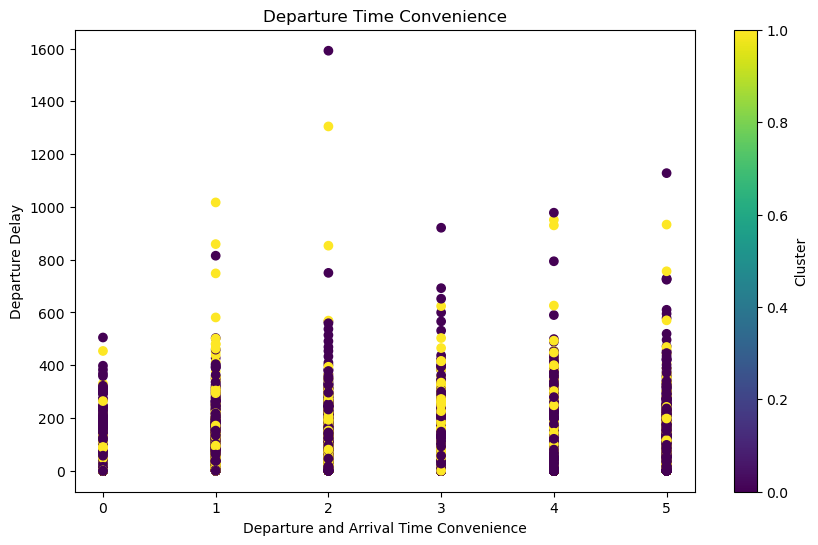

In [19]:
#convert the spark dataframe into pandas dataframe
predictions_pandas = predictions.select("ID", "features", "prediction").toPandas()
#convert the feature column(vector) into an array
features_pandas = predictions_pandas["features"].apply(lambda x: x.toArray())
#create a pandas dataframe from the above arrays
features_df = pd.DataFrame(features_pandas.tolist(), columns=feature_cols)
#add column 'cluster' to the dataframe
features_df["Cluster"] = predictions_pandas["prediction"]

#setup the plot size
plt.figure(figsize=(10, 6))
#create a scatter plot using matplotlib
plt.scatter(features_df["Departure and Arrival Time Convenience"], features_df["Departure Delay"], c=features_df["Cluster"], cmap="viridis", marker="o")
#set the x-axis label
plt.xlabel("Departure and Arrival Time Convenience")
#set the y-axis label
plt.ylabel("Departure Delay")
#set the plot title
plt.title("Departure Time Convenience")
#indicate the cluster assignments with a colour bar
plt.colorbar(label='Cluster')
#display the plot
plt.show()

**Determining the optimal number of clusters and highest silhouette score**

In [21]:
#define the range of clusters
k_values = range(2, 11)
#initialize a list to store tje silhouette scores
silhouette_scores = []
#iterate over each value of k
for k in k_values:
    #create a KMeans object for the current value of k
    kmeans = KMeans(featuresCol="features", k=k)
    #train the model on the data with current k value
    model = kmeans.fit(data)
    #apply the trained model to the data, assigning each data point to a cluster
    predictions = model.transform(data)
    #assess the cluster quality
    evaluator = ClusteringEvaluator(featuresCol="features")
    #compute the silhouette score for the current value of k
    silhouette = evaluator.evaluate(predictions)
    #append the computed score to the silhouette score list
    silhouette_scores.append(silhouette)
#find the best value of k that corresponds to the highest silhouette score
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
#print the optimal number of clusters with the corresponding silhouette score
print(f"Optimal number of clusters is {best_k}, and the Highest silhouette score is {max(silhouette_scores)}")

24/07/20 22:24:14 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Optimal number of clusters is 2, and the Highest silhouette score is 0.839834481430811


**Determining the most impacting features on customer satisfaction**

In [23]:
#header name
print("Feature Importances:")
#iterate over the feature importance list
for feature, importance in feature_importances:
    #print the feature name and its importance score
    print(f"{feature}: {importance}")

Feature Importances:
Age: -0.00014158095185396968
Flight Distance: 1.782177672190887e-05
Departure Delay: -0.00012564429464861682
Arrival Delay: -0.00034152109123717375
Departure and Arrival Time Convenience: -0.017504934758368475
Ease of Online Booking: -0.01385573207405859
Check-in Service: 0.0325287717796033
Online Boarding: 0.06993792131218883
Gate Location: -0.0018319267721343955
On-board Service: 0.03177809624993472
Seat Comfort: 0.01545610645585243
Leg Room Service: 0.0316582742166906
Cleanliness: 0.020458400354658596
Food and Drink: -0.0012162839158668696
In-flight Service: 0.015035598836151954
In-flight Wifi Service: 0.04660597466673648
In-flight Entertainment: 0.021957100506000114
Baggage Handling: 0.01695424537567271
GenderIndex: 0.008286451610506496
Customer_type_Index: -0.22251534626668204
Travel_type_Index: -0.2999038240119394
ClassIndex: -0.09475845051875414


In [24]:
#stop the spark session
spark.stop()